In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras import Model
import tensorflow.compat.v1.keras.backend as K

mnist = tf.keras.datasets.mnist
MODEL_PATH = 'models/mint_cnn_keras_v2.h5'

In [2]:
# data parameter
batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]


y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
60000 train samples
10000 test samples


In [4]:
## START OF SECTION THAT DOES NOT WORK

# Build basic model
model = tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                activation='relu',
                input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
# ^ IMPORTANT: notice that the final softmax must be in its own layer
# if we want to target pre-softmax units

model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [5]:
model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))
# save the weights
model.save(MODEL_PATH) 

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 99s 2ms/sample - loss: 0.2673 - accuracy: 0.9184 - val_loss: 0.0503 - val_accuracy: 0.9836


In [6]:
# run model
score = model.evaluate(x_test, y_test, verbose=2)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/1 - 5s - loss: 0.0262 - accuracy: 0.9836
Test loss: 0.05033166237685364
Test accuracy: 0.9836


In [7]:
# Import DeepExplain
from deepexplain.tf.v2_x import DeepExplain
# tf.compat.v1.keras.backend.get_session()
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    new_model = tf.keras.models.load_model(MODEL_PATH)
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = new_model.layers[0].input
    output_tensor = new_model.layers[-2].output

    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    # K.set_learning_phase(1)
    fModel = Model(inputs=input_tensor, outputs=output_tensor)

    target_tensor = fModel(input_tensor)

    xs = x_test[0:10]
    ys = y_test[0:10]
    #print(target_tensor.graph)
    #print(input_tensor.graph)

    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys)
    attributions_dl    = de.explain('deeplift', target_tensor, input_tensor, xs, ys=ys)
    attributions_elrp  = de.explain('elrp', target_tensor, input_tensor, xs, ys=ys)

Using tf version = 2.0.0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
from attribution method
from attribution method
from attribution method


/home/ax/miniconda3/envs/masterThesis_tf_2/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


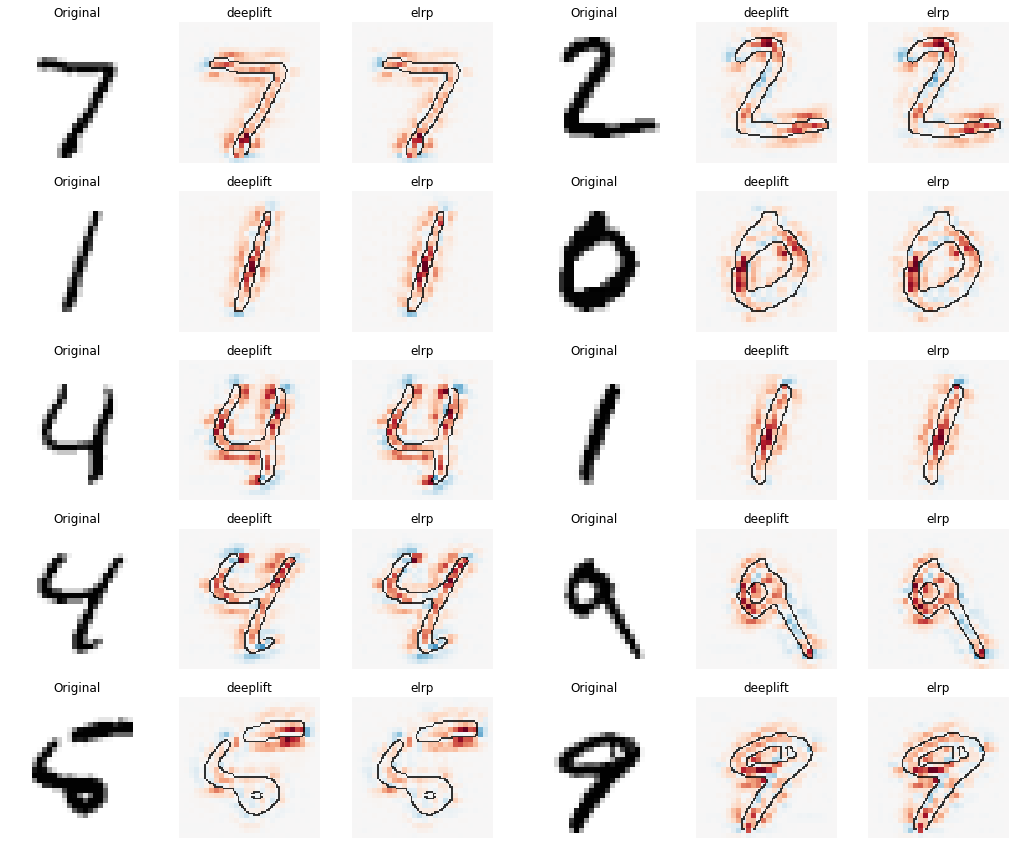

In [8]:
from utils import plot, plt
%matplotlib inline

n_cols = 6
n_rows = int(len(attributions_dl) / 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(3*n_cols, 3*n_rows))

for i, (a1, a2) in enumerate(zip(attributions_dl, attributions_elrp)):
    row, col = divmod(i, 2)
    plot(xs[i].reshape(28, 28), cmap='Greys', axis=axes[row, col*3]).set_title('Original')
    plot(a1.reshape(28,28), xi = xs[i], axis=axes[row,col*3+1]).set_title('deeplift')
    plot(a2.reshape(28,28), xi = xs[i], axis=axes[row,col*3+2]).set_title('elrp')

## Batch processing
In this example, we generate explanations for the entire testset (10000 images) using the fast Gradient*Input method.
`DeepExplain.explain()` accepts the `batch_size` parameter if the data to process does not fit in memory.

In [10]:
%%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    
    xs = x_test
    ys = y_test
    
    attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, xs, ys=ys, batch_size=128)
    print ("Done")

ValueError: Tensor("MaxPool:0", shape=(None, 12, 12, 64), dtype=float32) must be from the same graph as Tensor("keras_learning_phase:0", shape=(), dtype=bool).